__Purpose:__ Introduce Federated Learning, specifically by implementing FedAveraging on our dataset and moving on to more advanced methods.  Start by modifying the Simulations code, worry about (a)synchronicity later.
<br>
1. We are assuming we can test on the second half (updates 10-19ish) since (human/co-adaptive) learning should be complete by then!  For reasons shown in earlier NBs

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

# Reminder of Conditions Order

NOTE: 

* **CONDITIONS** = array(['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7','D_8']
* **LEARNING RATES:** alpha = 0.25 and 0.75; alpha = 0.25 for D1, D2, D5, D6; alpha = 0.75 for D3, D4, D7, D8
* **SMOOTHBATCH:** W_next = alpha*W_old + ((1 - alpha) * W_calc)

* **DECODER INIT:** pos for D1 - D4, neg for D5 - D8

* **PENALTY TERM:** $\lambda_E$ = 1e-6 for all, $\lambda_F$ = 1e-7 for all, $\lambda_D$ = 1e-3 for 1, 3, 5, 7 and 1e-4 for 2, 4, 6, 8 


| DECODER | ALPHA | PENALTY | DEC INIT |
| --- | --- | --- | --- |
| 1 | 0.25 | 1e-3 | + |
| 2 | 0.25 | 1e-4 | + |
| 3 | 0.75 | 1e-3 | + |
| 4 | 0.75 | 1e-4 | + |
| 5 | 0.25 | 1e-3 | - |
| 6 | 0.25 | 1e-4 | - |
| 7 | 0.75 | 1e-3 | - |
| 8 | 0.75 | 1e-4 | - |


# Verify Federated Set Up Runs

In [3]:
with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

In [4]:
D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

Quick runs just to make sure each algo runs without issues

In [5]:
#Check streaming condition
user_c0_etascipy_streaming = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0) for i in range(14)]
global_model = Server(-100, D_0_7, 'FedAvg', user_c0_etascipy_streaming)
global_model.execute_FL_loop()
global_model.execute_FL_loop()

#Check full data condition
user_c0_etascipy_full = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'full_data', delay_scaling=0) for i in range(14)]
global_model = Server(-101, D_0_7, 'FedAvg', user_c0_etascipy_full)
global_model.execute_FL_loop()
global_model.execute_FL_loop()

#Check advance_each_iter condition
user_c0_etascipy_advance = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model = Server(-102, D_0_7, 'FedAvg', user_c0_etascipy_advance)
global_model.execute_FL_loop()
global_model.execute_FL_loop()

Check the non-PCA case now... this is no longer the default
> This one should overwrite

In [6]:
user_c0_etascipy_streaming = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model = Server(-103, D_0_7, 'FedAvg', user_c0_etascipy_streaming, PCA_comps=64)

global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))

(1, 1, 10)


In [7]:

global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
global_model.execute_FL_loop()
print((global_model.current_round, global_model.all_clients[0].current_round, global_model.all_clients[0].current_update))
print()
print("Confirmation that no PCA happened (size should be 64)")
print(user_c0_etascipy_streaming[0].w.shape)
print(user_c0_etascipy_streaming[0].w_prev.shape)

(2, 1, 10)
(3, 1, 10)

Confirmation that no PCA happened (size should be 64)
(2, 64)
(2, 64)


## No-FL Case
> We should see some kind of convergence <br>
> Ideally this should mirror NB200 <br>
> TURNING PCA OFF FOR THIS CASE SINCE SIMS DID NOT HAVE IT <br>

Check the performance... should approximately mirror the previous NB, or at least show that error is decreasing...

In [8]:
user_c0_no_fl_w_cphs_init = [Client(i, cond0_init_decs[i], 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, normalize_EMG=False, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl_w_cphs_init = Server(-1, D_0, 'NoFL', user_c0_no_fl_w_cphs_init, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_model_no_fl_w_cphs_init.execute_FL_loop()
print(f"Global Round: {global_model_no_fl_w_cphs_init.current_round}")
print()
print(f"Local Round: {user_c0_no_fl_w_cphs_init[0].current_round}")
print(f"Local Update: {user_c0_no_fl_w_cphs_init[0].current_update}")

Global Round: 18

Local Round: 18
Local Update: 16


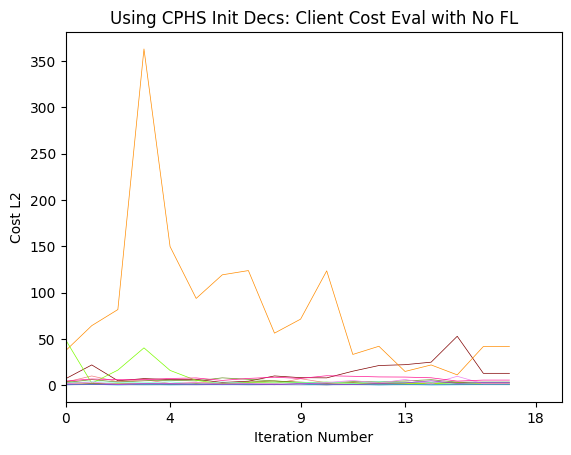

In [9]:
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='Using CPHS Init Decs: Client Cost Eval with No FL')

__Excluding the bad nodes__

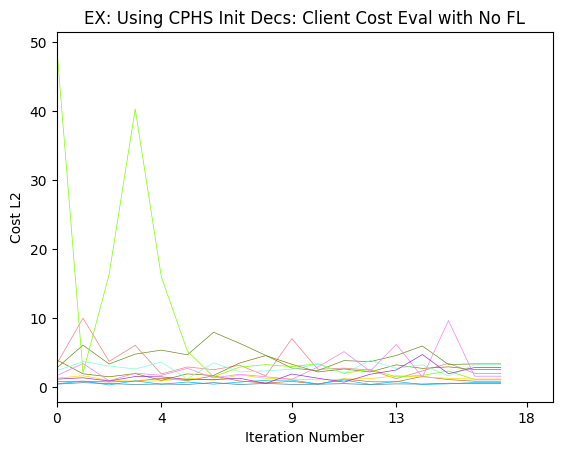

In [10]:
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', exclusion_ID_lst=bad_nodes, global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='EX: Using CPHS Init Decs: Client Cost Eval with No FL')

Performance, normD, and normF

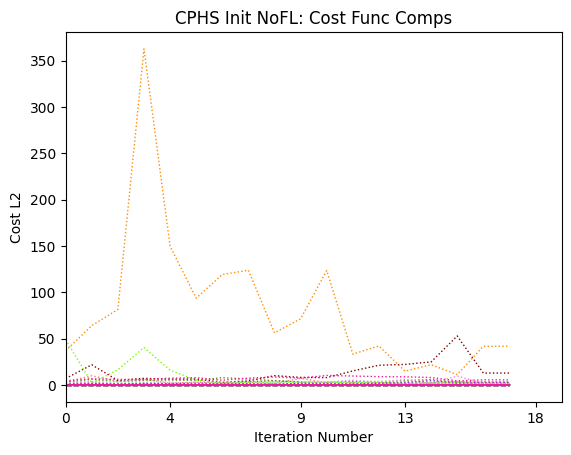

In [11]:
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', dim_reduc_factor=1, global_error=False, local_error=False, plot_performance=True, plot_Dnorm=True, plot_Fnorm=True, custom_title='CPHS Init NoFL: Cost Func Comps')

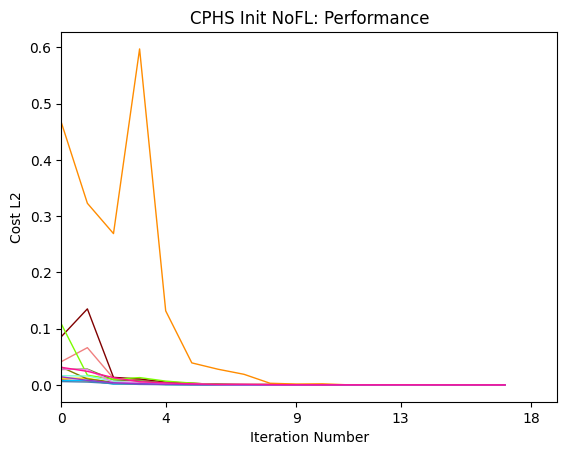

In [12]:
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', dim_reduc_factor=1, global_error=False, local_error=False, plot_performance=True, custom_title='CPHS Init NoFL: Performance')

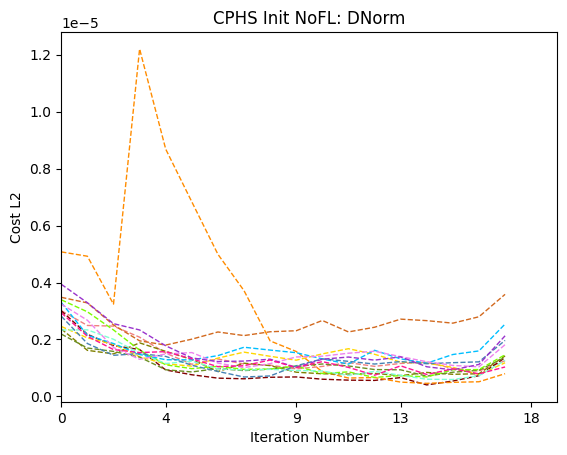

In [13]:
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', dim_reduc_factor=1, global_error=False, local_error=False, plot_Dnorm=True, custom_title='CPHS Init NoFL: DNorm')

Currently, the F normalization is turned off

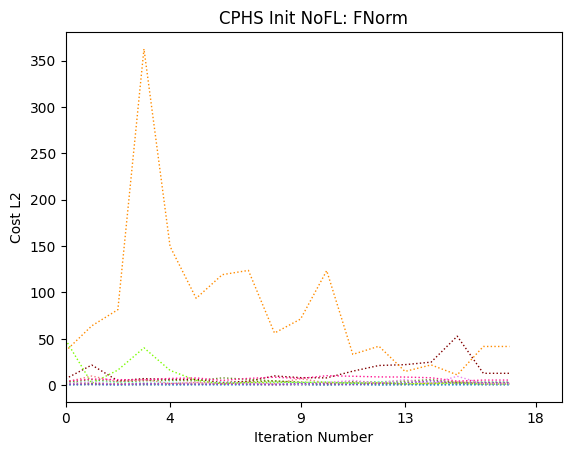

In [14]:
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', dim_reduc_factor=1, global_error=False, local_error=False, plot_Fnorm=True, custom_title='CPHS Init NoFL: FNorm')

__Since each update gets a new batch of data, gradient will be jumpy, this is expected__

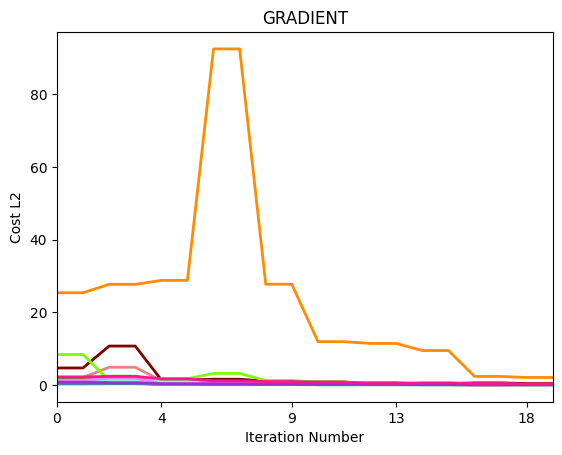

In [15]:
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', plot_gradient=True, dim_reduc_factor=1, local_error=False, global_error=False, show_update_change=False, custom_title='GRADIENT')

Turn on F normalization and see what happens

In [16]:
user_c0_no_fl_w_cphs_init = [Client(i, cond0_init_decs[i], 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', global_method='NoFL', track_cost_components=True, PCA_comps=64, delay_scaling=0) for i in range(14)]
global_model_no_fl_w_cphs_init = Server(-1, D_0, 'NoFL', user_c0_no_fl_w_cphs_init, PCA_comps=64)

num_updates_left = 18
for i in range(num_updates_left):
    global_model_no_fl_w_cphs_init.execute_FL_loop()
print(f"Global Round: {global_model_no_fl_w_cphs_init.current_round}")
print()
print(f"Local Round: {user_c0_no_fl_w_cphs_init[0].current_round}")
print(f"Local Update: {user_c0_no_fl_w_cphs_init[0].current_update}")

Global Round: 18

Local Round: 18
Local Update: 16


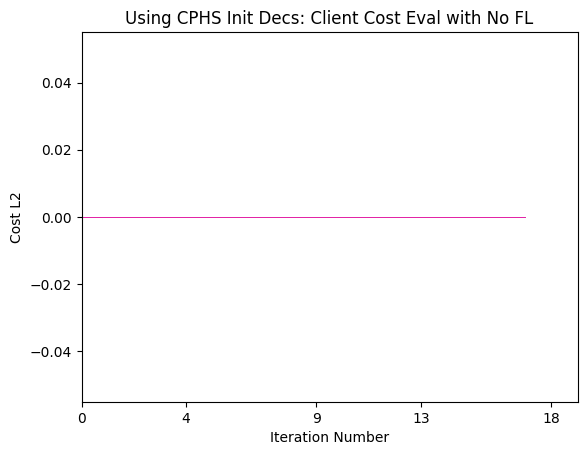

In [17]:
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='Using CPHS Init Decs: Client Cost Eval with No FL')

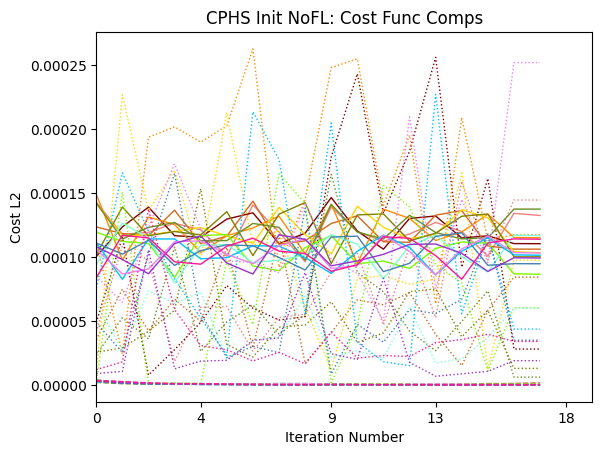

In [18]:
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', dim_reduc_factor=1, global_error=False, local_error=False, plot_performance=True, plot_Dnorm=True, plot_Fnorm=True, custom_title='CPHS Init NoFL: Cost Func Comps')

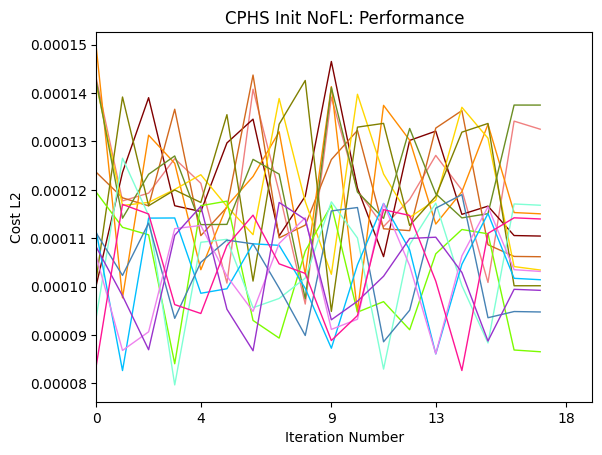

In [19]:
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', dim_reduc_factor=1, global_error=False, local_error=False, plot_performance=True, custom_title='CPHS Init NoFL: Performance')

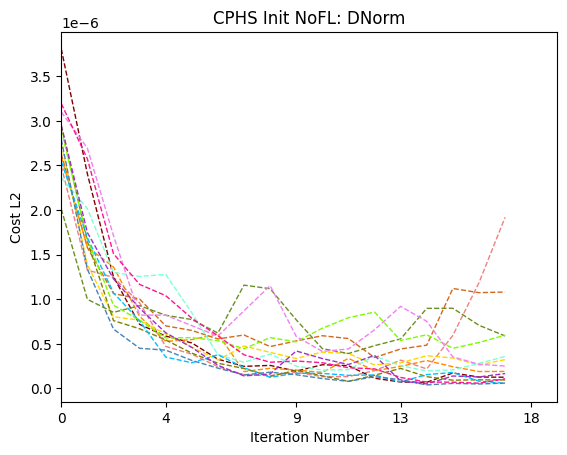

In [20]:
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', dim_reduc_factor=1, global_error=False, local_error=False, plot_Dnorm=True, custom_title='CPHS Init NoFL: DNorm')

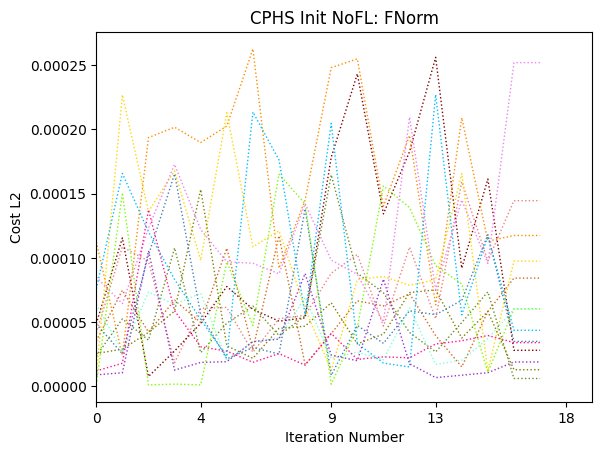

In [21]:
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', dim_reduc_factor=1, global_error=False, local_error=False, plot_Fnorm=True, custom_title='CPHS Init NoFL: FNorm')

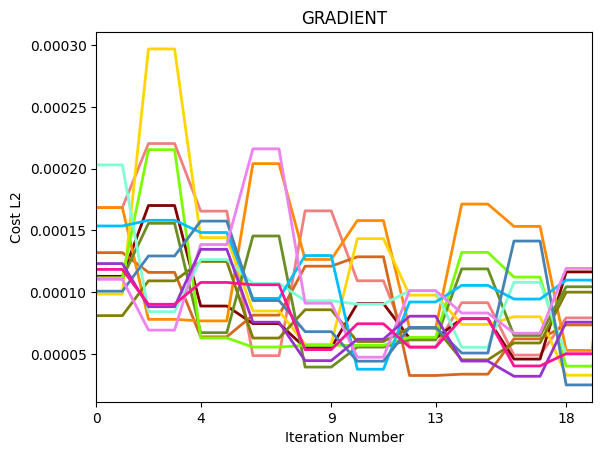

In [22]:
condensed_external_plotting(user_c0_no_fl_w_cphs_init, 'local', plot_gradient=True, local_error=False, global_error=False, dim_reduc_factor=1, show_update_change=False, custom_title='GRADIENT')

> Everything below this has EMG (F) Normalization on by default...

# Federated Learning
## 1 Scipy Step, 2000 Iterations
> Note that the thicker, lighter lines are the global model accuracies, whereas the thin lines are the local accuracies.

In [23]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep)

big_loop_iters = 2000
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 290, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 640, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 939, 150)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 1223, 200)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 1514, 250)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 1776, 300)



In [24]:
print("(Current Local Round, Current Local Update)")
for my_client in global_model_1scipystep.all_clients:
    print((my_client.current_round, my_client.current_update))

(Current Local Round, Current Local Update)
(300, 16)
(342, 16)
(260, 15)
(299, 15)
(263, 15)
(285, 15)
(294, 15)
(266, 15)
(311, 16)
(277, 15)
(266, 15)
(291, 15)
(264, 15)
(282, 15)


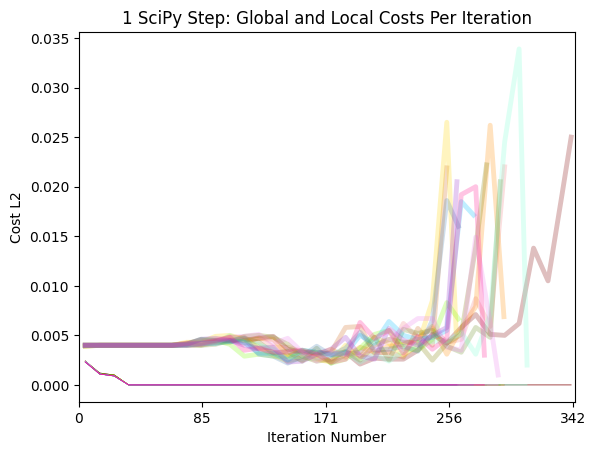

In [25]:
condensed_external_plotting(user_c0_1ScipyStep, 'local', custom_title='1 SciPy Step: Global and Local Costs Per Iteration')

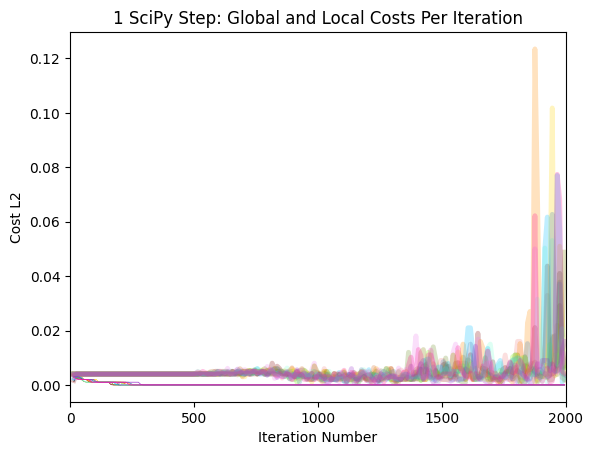

In [26]:
condensed_external_plotting(global_model_1scipystep, 'global', show_update_change=False, custom_title='1 SciPy Step: Global and Local Costs Per Iteration')

Performance, normD, and normF

In [27]:
user_c0_1ScipyStep[0].F.shape

(7, 600)

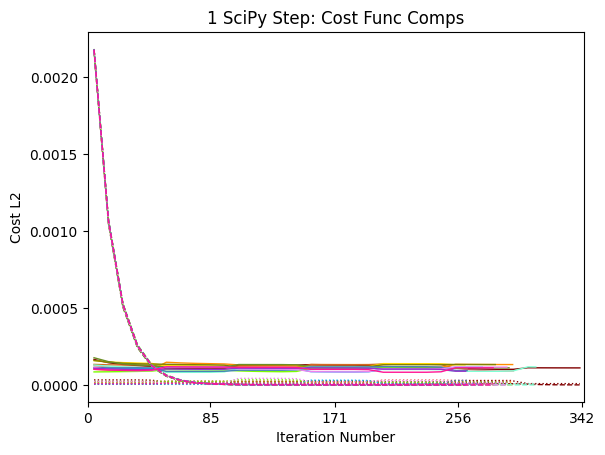

In [28]:
condensed_external_plotting(user_c0_1ScipyStep, 'local', global_error=False, local_error=False, plot_performance=True, plot_Dnorm=True, plot_Fnorm=True, custom_title='1 SciPy Step: Cost Func Comps')

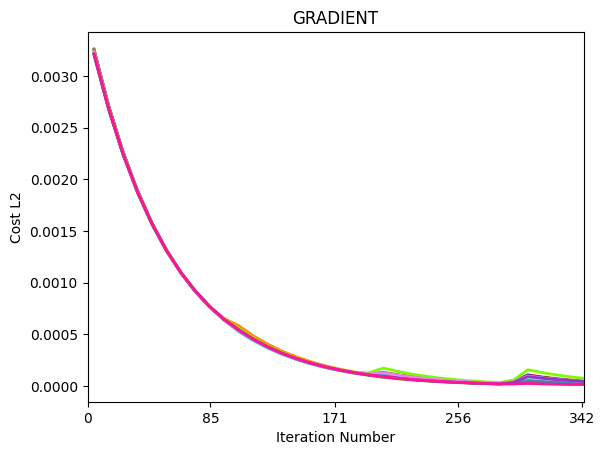

In [29]:
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, show_update_change=False, custom_title='GRADIENT')

__Repeat but now actually make it much smaller__

In [30]:
reduced_limit = 25

user_c0_1ScipyStep_lim25 = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep_lim25 = Server(1, D_0_7, 'FedAvg', user_c0_1ScipyStep_lim25)

for i in range(big_loop_iters):
    global_model_1scipystep_lim25.execute_FL_loop()

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 176, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 358, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 539, 75)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 675, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 853, 125)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 995, 150)



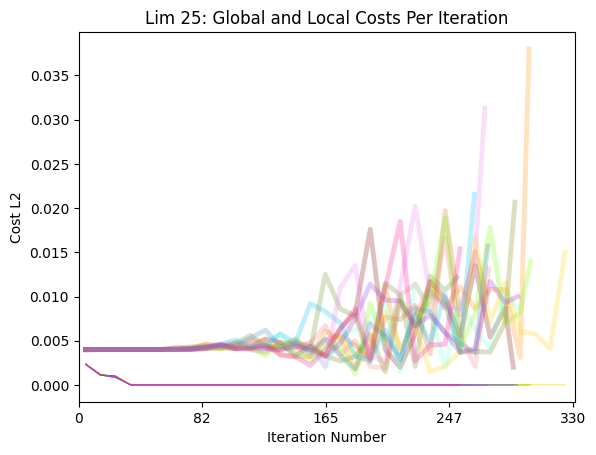

In [31]:
condensed_external_plotting(user_c0_1ScipyStep_lim25, 'local', custom_title='Lim 25: Global and Local Costs Per Iteration')

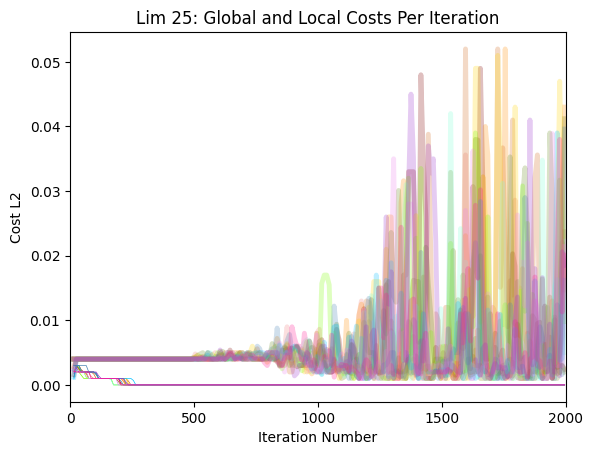

In [32]:
condensed_external_plotting(global_model_1scipystep_lim25, 'global', show_update_change=False, custom_title='Lim 25: Global and Local Costs Per Iteration')

## 10 Steps

In [33]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvg', user_c0_10scipy)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()

In [34]:
for my_client in global_model_10scipy.all_clients:
    print((my_client.current_round, my_client.current_update))

(278, 15)
(272, 15)
(289, 15)
(301, 16)
(287, 15)
(294, 15)
(284, 15)
(283, 15)
(275, 15)
(292, 15)
(276, 15)
(281, 15)
(291, 15)
(297, 15)


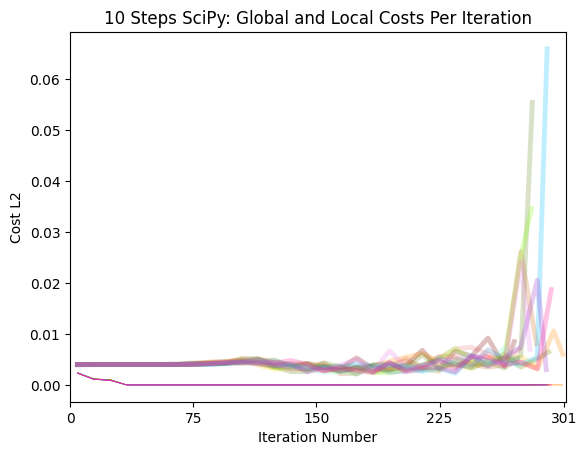

In [35]:
condensed_external_plotting(user_c0_10scipy, 'local', custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')

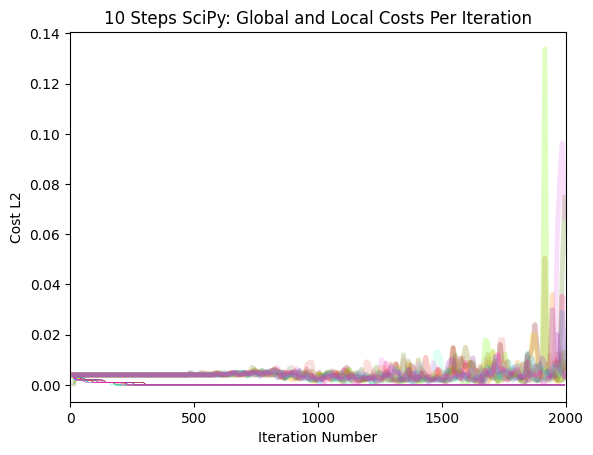

In [36]:
condensed_external_plotting(global_model_10scipy, 'global', custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')

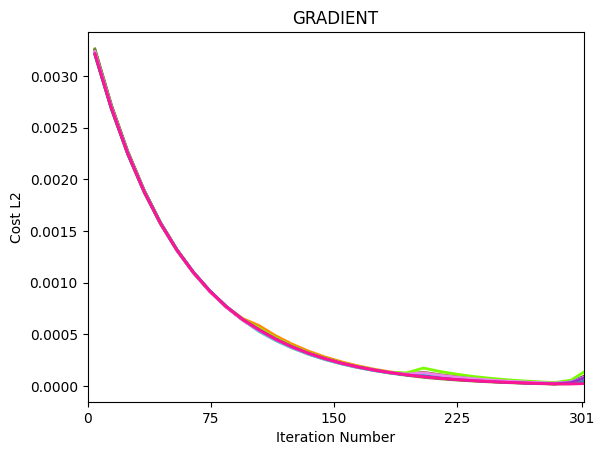

In [37]:
condensed_external_plotting(user_c0_10scipy, 'local', plot_gradient=True, local_error=False, global_error=False, show_update_change=False, custom_title='GRADIENT')

## Full Scipy.Minimize
> Remember we are starting at update 10 already!!

In [38]:
user_c0_fullscipy = [Client(i, D_0_7, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model_fullscipy = Server(4, D_0_7, 'FedAvg', user_c0_fullscipy, C=1)

for i in range(8):
    global_model_fullscipy.execute_FL_loop()

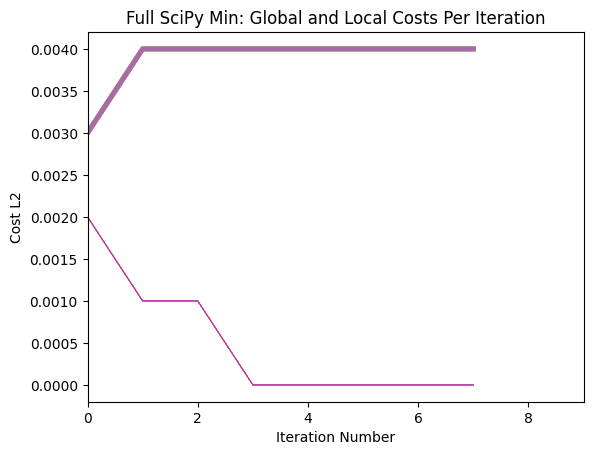

In [39]:
condensed_external_plotting(user_c0_fullscipy, 'local', dim_reduc_factor=1, show_update_change=False, custom_title='Full SciPy Min: Global and Local Costs Per Iteration')

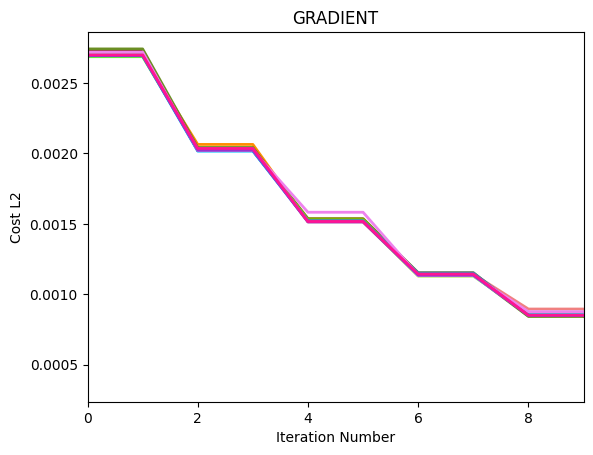

In [40]:
condensed_external_plotting(user_c0_fullscipy, 'local', plot_gradient=True, local_error=False, global_error=False, show_update_change=False, dim_reduc_factor=1, custom_title='GRADIENT')

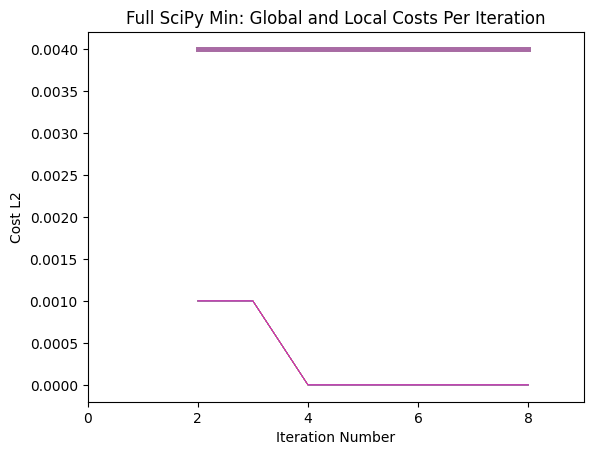

In [41]:
condensed_external_plotting(global_model_fullscipy, 'global', dim_reduc_factor=1, show_update_change=False, custom_title='Full SciPy Min: Global and Local Costs Per Iteration')

# Exclude Deviant Clients
> Eg 1 and 3

In [42]:
reduced_limit = 25

user_c0_1SS_l25 = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming',  local_round_threshold=reduced_limit, delay_scaling=0, verbose=True) for i in range(14)]
user_c0_1SS_l25_ex = [my_client for my_client in user_c0_1SS_l25 if my_client.ID not in bad_nodes]
global_model_1SS_l25_ex = Server(1, D_0_7, 'FedAvg', user_c0_1SS_l25_ex)

big_loop_iters = 2000
for i in range(big_loop_iters):
    global_model_1SS_l25_ex.execute_FL_loop()

IndexError: list index out of range

I have to refactor the code to fix that issue... probably need to switch to dictionaries or something since I can't use ID as the index...

In [ ]:
condensed_external_plotting(user_c0_1SS_l25_ex, 'local', custom_title='Lim 25: Global and Local Costs Per Iteration')

In [ ]:
condensed_external_plotting(global_model_1SS_l25_ex, 'global', custom_title='Lim 25: Global and Local Costs Per Iteration')